**Question 1**

Setting up the process

In [37]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=69420)     # set up random number generator with fixed seed for reproducability

Generating the spikes, uses the exponential distribution to determine the time to the next spike. Could be optmised, calculating both the homo and inhomo case while only returning one is silly

In [38]:
def SpikeGeneration(timeStop = 1, homo = True, refractory = 0.05, expected = 35):
    # refractory is minimum time between spikes for the inhomogeneous case
    # expected is lambda in the exponential distribution
    spikesHomo = []
    spikesInhomo = []
    timeTotal = 0
    while timeTotal < timeStop:
        time = rng.exponential(1/expected)
        timeTotal += time
        if timeTotal > timeStop:
            break
    
        spikesHomo.append(timeTotal)
        if len(spikesInhomo) == 0:
            spikesInhomo.append(timeTotal)
        # what are the odds that no spikes occur over the period?
        # High apparently
        elif timeTotal - spikesInhomo[-1] > refractory:
            spikesInhomo.append(timeTotal)

    if homo == True: return spikesHomo
    elif homo == False: return spikesInhomo


Calculating the ISI coefficient, $C_{ISI} = \frac{\sigma}{\mu}$

In [39]:
def ISICoeff(spikes):
    spikeISI = []
    for spike in range (0, len(spikes)):
        if spike == 0: pass
        else:
            spikeISI.append(spikes[spike] - spikes[spike - 1])

    return np.std(spikeISI) / np.mean(spikeISI)

Calculating the Inter Spike Interval coefficient for the two created spike trains

In [40]:
spikesHomo = SpikeGeneration()
spikesInhomo = SpikeGeneration(homo = False)
cHomo = ISICoeff(spikesHomo)
cInhomo = ISICoeff(spikesInhomo)

In [41]:
print(cHomo)
print(cInhomo)
# cHomo should be ~1, I assume cInhomo should be less than

0.8258735087580551
0.33422870379391895


Calculating the fano factor for a given set of spike trains, $F=\frac{\sigma^2}{\mu}$

In [42]:
def FanoFactor(spikes):
    # spikes should be a 2D array with D-1 being the differing runs & D-2 the spikes in those runs
    # the function calculates the spike counts for the runs and returns the fano factor
    # !!!!TAKES THE VECTOR OF SPIKE TIMES!!!! NOT SPIKES THEMSELVES
    spikeCounts = [len(run) for run in spikes]     # python indexes from 0
    return np.var(spikeCounts) / np.mean(spikeCounts)

Calculating the fano factor for the homogeneous case, the inhomogeneous case needs to be run over multiple $\Delta t$ so is done seperately 

In [50]:
runCount = 10
spikesHomo = []
for run in range(0, runCount):
    spikesHomo.append(SpikeGeneration())

print(FanoFactor(spikesHomo))

0.1328767123287671


Calculating the fano factor for the inhomogeneous case for $\Delta t$ = 10ms, 50ms, 100ms

In [44]:
times = [0.01, 0.05, 0.1]
spikesInhomo = []
for time in times:
    spikesTemp = []
    for run in range(0, runCount):
        spikesTemp.append(SpikeGeneration(timeStop = time, homo = False))

    spikesInhomo.append(spikesTemp)

fanoFactor = []
for spikes in spikesInhomo:
    fanoFactor.append(FanoFactor(spikes))

print(fanoFactor)

[0.6000000000000001, 0.19999999999999998, 0.31428571428571433]


Part iv, gotta plot the ISI and fano factor for $\Delta t$ = 100ms with $refractory \in [0ms, 28ms]$

Text(0.5, 0, 'Refractory period (ms)')

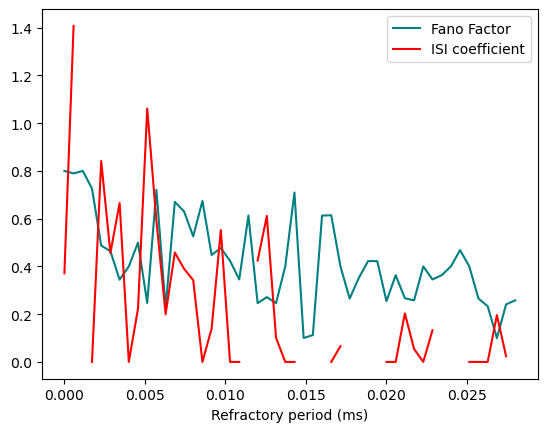

In [45]:
# 0ms refractory is special case, where the process in homogeneous to avoid floating point errors
ISI = []
fano = []
spikesTemp = []
refractory = np.linspace(0, 0.028)
ISI.append(ISICoeff(SpikeGeneration(timeStop = 0.1)))
for run in range(0, runCount):
    spikesTemp.append(SpikeGeneration(timeStop = 0.1))

fano.append(FanoFactor(spikesTemp))

# inhomogeneous process
for refracTime in refractory[1:]:
    ISI.append(ISICoeff(SpikeGeneration(timeStop = 0.1, refractory = refracTime, homo=False)))
    spikesTemp = []
    for run in range(0, runCount):
        spikesTemp.append(SpikeGeneration(timeStop = 0.1, refractory = refracTime, homo=False))

    fano.append(FanoFactor(spikesTemp))


fig, ax = plt.subplots()

ax.plot(refractory, fano, color='teal', label='Fano Factor')
ax.plot(refractory, ISI, color='red', label='ISI coefficient')
ax.legend()
ax.set_xlabel('Refractory period (ms)')

# missing values are due to divsion by zero, can be fixed by increasing delta t but the question asks for it to be 100ms

In [46]:
print(ISI)

[0.3712548045889739, 1.4074085272515664, nan, 0.0, 0.8414983735655532, 0.45619314499262004, 0.6658980925922933, 0.0, 0.22338734922881434, 1.0615091779747197, 0.5905132801106836, 0.19966606271218287, 0.45824082069914174, 0.39057700036804394, 0.3421240215311779, 0.0, 0.13971576306252337, 0.5521130731603184, 0.0, 0.0, nan, 0.4247703663080737, 0.611281039055209, 0.10101222870106874, 0.0, 0.0, nan, 0.1854146561303928, nan, 0.0, 0.06595130836695468, nan, 0.0, nan, nan, 0.0, 0.0, 0.20351222244078312, 0.05400487683964877, 0.0, 0.1325979756027152, nan, nan, nan, 0.0, 0.0, 0.0, 0.1962184487559584, 0.023808749844005862, nan]


<b>Question 2</b>

In [74]:
# reading and converting file to numbers
with open('rho.dat', 'r') as data:
    spikes = [line.rsplit() for line in data]

# this line is so dumb
spikes = [int(spike[0]) for spike in spikes]

# convert the spikes into a time series
deltaT = 0.002

# this line is dumber no way this is what im supposed to be doing
spikeTimes = [deltaT*spikeCount*spike for spikeCount, spike in zip(range(0, len(spikes)), spikes) if deltaT*spikeCount*spike != 0]

ISI = ISICoeff(spikeTimes)
print(ISI)

# bin size of 1 is a special case
spikesBinned1 = [[spike] if spike else [] for spike in spikes]

# this is a bit fucked and im not sure why it works but i went through 6 different comprehension attempts
binSizes = [5, 25, 50]
spikesBinned = []
for binSize in binSizes:
    spikesTemp = []
    # stole these 2 lines from stackoverflow
    for i in range(0, len(spikes), binSize):
        spikesTemp.append(spikes[i:i + binSize])

    # removes any instance of no spike from the list so that using len() can count the spikes
    # this is the reason bin size of 1 is a special case
    for x in spikesTemp:
        while x.count(0):
            x.remove(0)
    spikesBinned.append(spikesTemp)

# actually doing the fano factor, again bin size 1 is treated seperately
fano1 = FanoFactor(spikesBinned1)
fano = [FanoFactor(spike) for spike in spikesBinned]
print(fano1)
print(fano)

2.0085523370640965
[]
0.9106650000000001
[1.117680142627936, 2.9297562848640877, 4.102959520344769]


The ISI coefficient is higher than expected for a poisson process, suggesting this spike train is more irregular than a poisson process. The fano factor for bin size 2ms was only slightly lower than 1, suggesting more regularity than a poisson process but this may be a statistical error. The higher the bin size the higher the fano factor with bin size >=5ms having a fano factor higher than would be expected for a poisson process, and thus more regular.